In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import analyze
import raybay

In [2]:
# Load treatment plan results
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)
result = np.load('grid/res_grid_1.pkl', allow_pickle=True)

In [4]:
# Reload goal and function dataframes (doesn't save correctly from remote)
result.goal_df = pd.read_csv('goals.csv') 
result.func_df = pd.read_csv('grid/funcs.csv')
pickle.dump(result, open('grid/res_grid_1.pkl', 'wb'))

In [5]:
# Clinical goals
result.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,ChestWall,MaxDvh,AtMost,3000,9.33
1,D2CM,MaxDose,AtMost,2400,NaN
2,Esophagus,MaxDvh,AtMost,1880,20.19
3,Lung_Total-GTV,MaxDvh,AtMost,1160,85.52
4,Lung_Total-GTV,MaxDvh,AtMost,1240,57.01
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Ribs,MaxDvh,AtMost,3200,1.51
8,Ribs,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,3.25


In [6]:
# Constituent Functions
result.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,ChestWall,MaxDvh,3000,9.33,NaN,1
1,D2CM,MaxDose,"[0,2400]",0.00,NaN,1
2,Esophagus,MaxDvh,1880,20.19,NaN,1
3,Lung_Total-GTV,MaxDvh,1160,85.52,NaN,1
4,Lung_Total-GTV,MaxDvh,1240,57.01,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,8000,0.00,NaN,1
7,Ribs,MaxDvh,3200,1.51,NaN,1
8,Ribs,MaxDose,4000,0.00,NaN,1
9,SpinalCanal,MaxDvh,1360,3.25,NaN,1


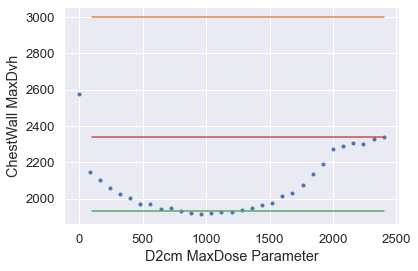

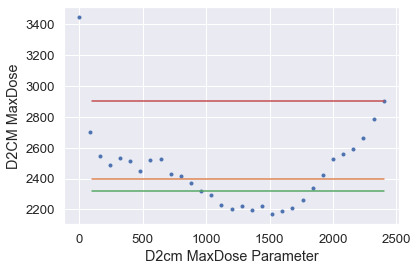

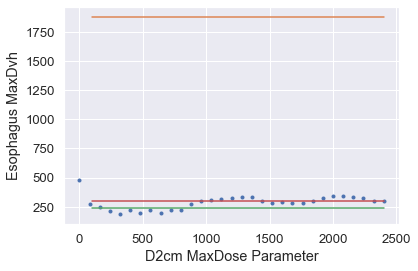

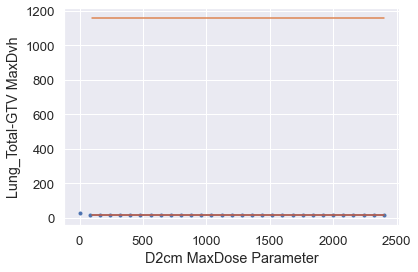

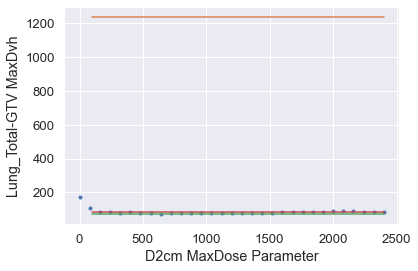

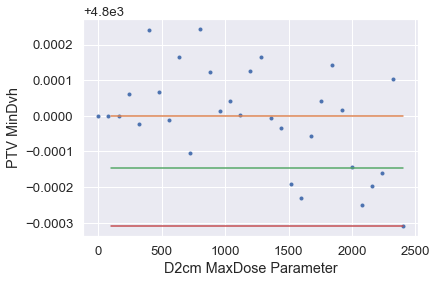

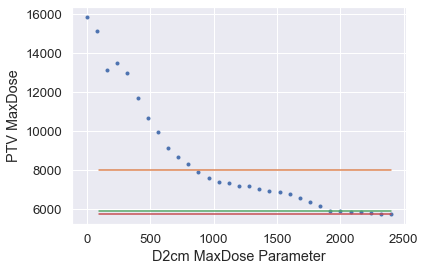

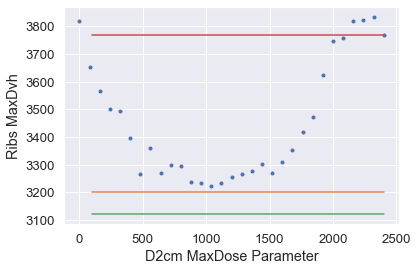

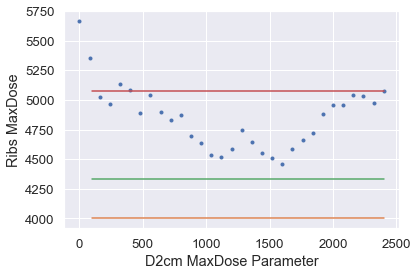

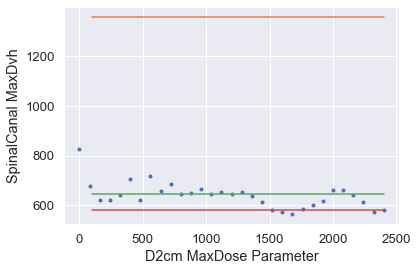

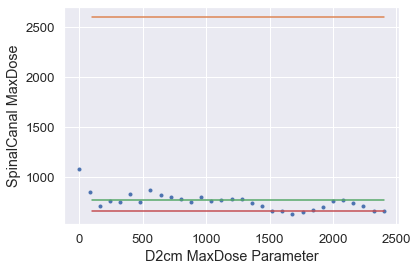

In [11]:
# Parameter vs. Goal Values
for index, row in result.goal_df.iterrows():
    plt.figure()
    plt.plot(result.opt_result.x_iters[1:], result.goal_dict[index][1:], '.')
    plt.plot([100, 2400], [row['AcceptanceLevel'], row['AcceptanceLevel']])
    plt.plot([100, 2400], [approved.goal_dict[index], approved.goal_dict[index]])
    plt.plot([100, 2400], [default.goal_dict[index], default.goal_dict[index]])
    plt.xlabel('D2cm MaxDose Parameter')
    plt.ylabel(f"{row['Roi']} {row['Type']}")

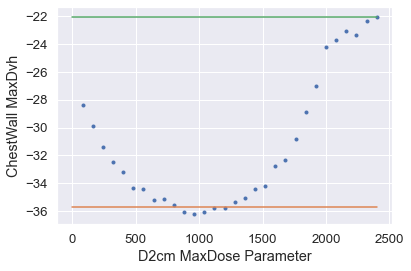

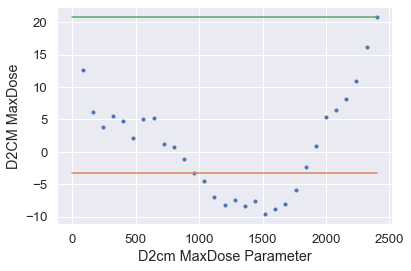

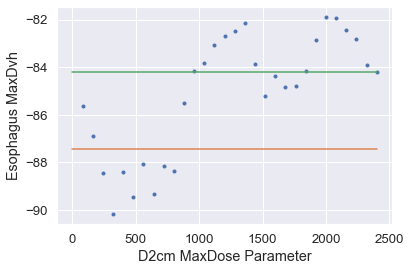

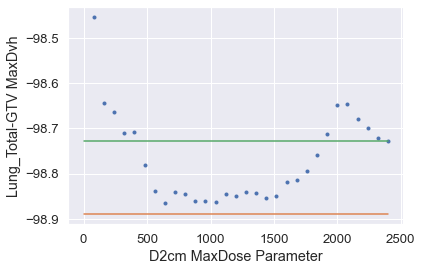

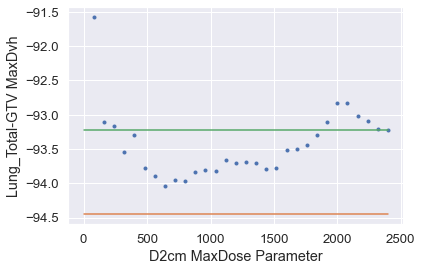

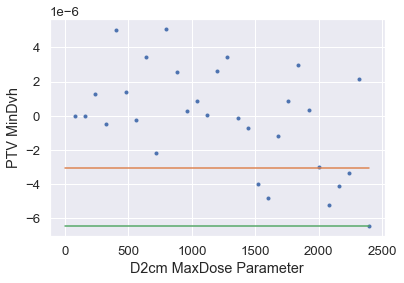

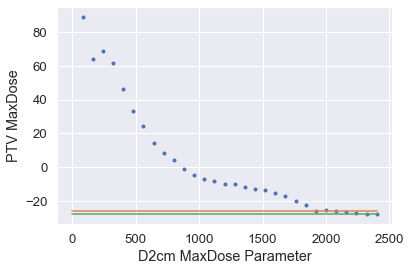

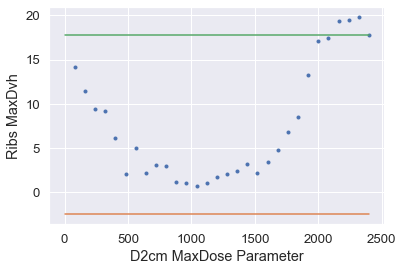

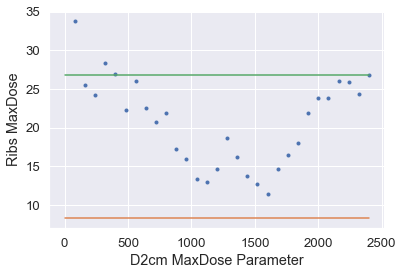

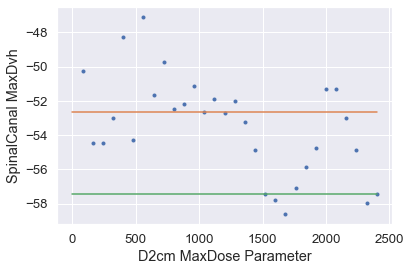

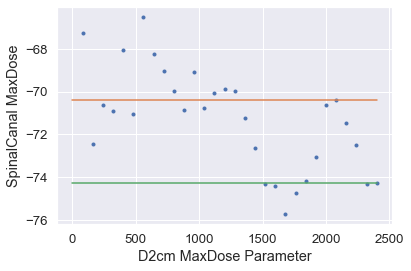

In [8]:
# Parameter vs. Goal Percentages
for index, row in result.goal_df.iterrows():
    plt.figure()
    app_percent = 100*(approved.goal_dict[index] - result.goal_df.iloc[index]['AcceptanceLevel'])/result.goal_df.iloc[index]['AcceptanceLevel']
    def_percent = 100*(default.goal_dict[index] - result.goal_df.iloc[index]['AcceptanceLevel'])/result.goal_df.iloc[index]['AcceptanceLevel']
    percent = 100*(result.goal_dict[index] - result.goal_df.iloc[index]['AcceptanceLevel'])/result.goal_df.iloc[index]['AcceptanceLevel']
    plt.plot(result.opt_result.x_iters[1:], percent[1:], '.')
    plt.plot([0, 2400], [app_percent, app_percent])
    plt.plot([0, 2400], [def_percent, def_percent])
    plt.xlabel('D2cm MaxDose Parameter')
    plt.ylabel(f"{row['Roi']} {row['Type']}")

19


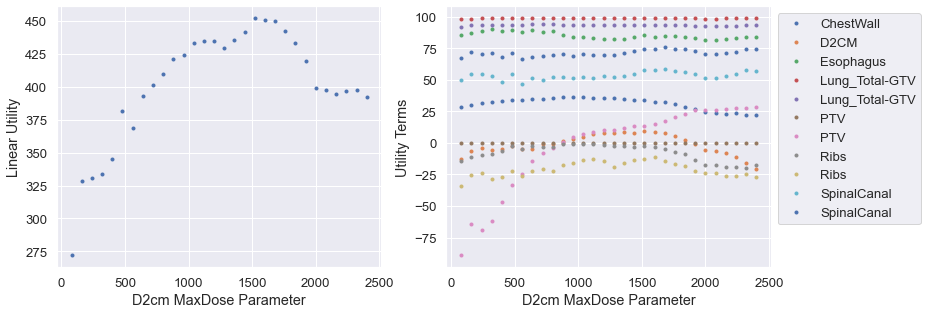

In [16]:
# Linear Utility
weights = [1.0]*11
shapes = ['linear']*11
util = raybay.get_utility(result.goal_df, result.goal_dict, weights, shapes)
print(np.argmax(util))

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(result.opt_result.x_iters[1:], util[1:], '.')
ax[0].set_xlabel('D2cm MaxDose Parameter')
ax[0].set_ylabel('Linear Utility')

for index, row in result.goal_df.iterrows():
    terms = [raybay.get_term(result.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear') for ii in range(31)]
    ax[1].plot(result.opt_result.x_iters[1:], terms[1:], '.')
    ax[1].set_xlabel('D2cm MaxDose Parameter')
    ax[1].set_ylabel('Utility Terms')
    ax[1].legend(result.goal_df['Roi'], bbox_to_anchor=(1, 1))

20


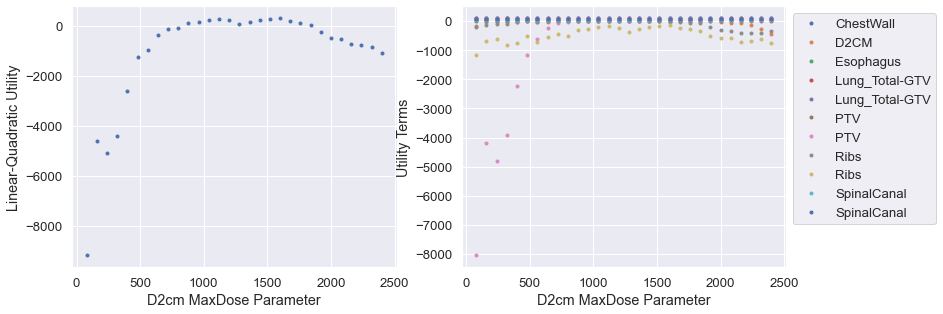

In [17]:
# Linear-Quadratic Utility
weights = [1.0]*11
shapes = ['linear_quadratic']*11
util = raybay.get_utility(result.goal_df, result.goal_dict, weights, shapes)
print(np.argmax(util))

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(result.opt_result.x_iters[1:], util[1:], '.')
ax[0].set_xlabel('D2cm MaxDose Parameter')
ax[0].set_ylabel('Linear-Quadratic Utility')

for index, row in result.goal_df.iterrows():
    terms = [raybay.get_term(result.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear_quadratic') for ii in range(31)]
    ax[1].plot(result.opt_result.x_iters[1:], terms[1:], '.')
ax[1].set_xlabel('D2cm MaxDose Parameter')
ax[1].set_ylabel('Utility Terms')
ax[1].legend(result.goal_df['Roi'], bbox_to_anchor=(1, 1))

19


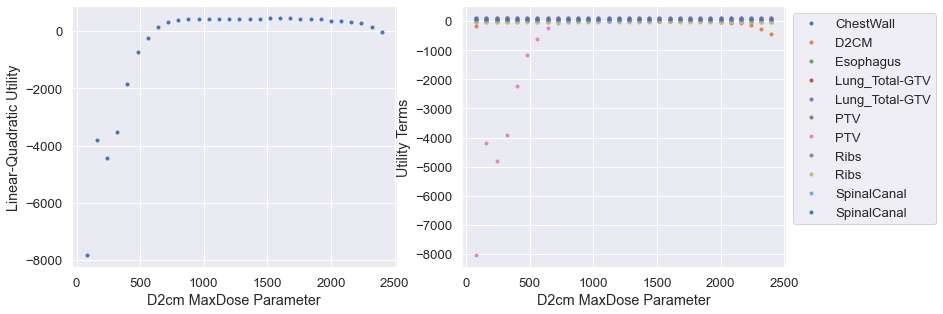

In [18]:
# Linear-Quadratic Utility with Linear Rib
weights = [1.0]*11
shapes = ['linear_quadratic']*11
shapes[7] = 'linear'
shapes[8] = 'linear'
util = raybay.get_utility(result.goal_df, result.goal_dict, weights, shapes)
print(np.argmax(util))

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(result.opt_result.x_iters[1:], util[1:], '.')
ax[0].set_xlabel('D2cm MaxDose Parameter')
ax[0].set_ylabel('Linear-Quadratic Utility')

for index, row in result.goal_df.iterrows():
    shape = 'linear' if 'Rib' in row['Roi'] else 'linear_quadratic'
    terms = [raybay.get_term(result.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], shape) for ii in range(31)]
    ax[1].plot(result.opt_result.x_iters[1:], terms[1:], '.')
ax[1].set_xlabel('D2cm MaxDose Parameter')
ax[1].set_ylabel('Utility Terms')
ax[1].legend(result.goal_df['Roi'], bbox_to_anchor=(1, 1))

20


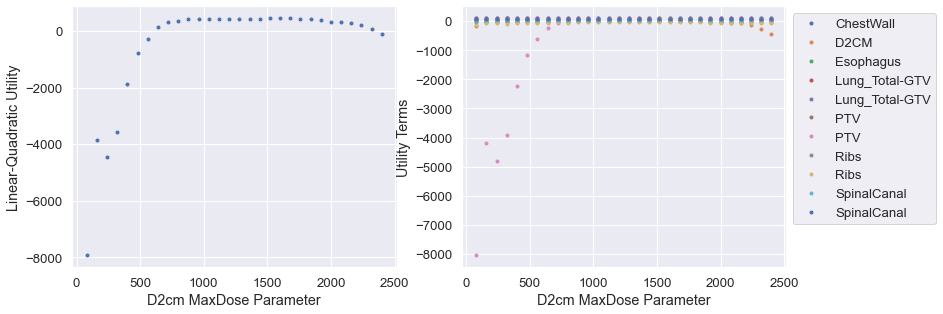

In [20]:
# Linear-Quadratic Utility with Lower Rib Weight
weights = [1.0]*11
weights[7] = 0.1
weights[8] = 0.1
shapes = ['linear_quadratic']*11
util = raybay.get_utility(result.goal_df, result.goal_dict, weights, shapes)
print(np.argmax(util))

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(result.opt_result.x_iters[1:], util[1:], '.')
ax[0].set_xlabel('D2cm MaxDose Parameter')
ax[0].set_ylabel('Linear-Quadratic Utility')

for index, row in result.goal_df.iterrows():
    terms = [weights[index]*raybay.get_term(result.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], shape) for ii in range(31)]
    ax[1].plot(result.opt_result.x_iters[1:], terms[1:], '.')
ax[1].set_xlabel('D2cm MaxDose Parameter')
ax[1].set_ylabel('Utility Terms')
ax[1].legend(result.goal_df['Roi'], bbox_to_anchor=(1, 1))

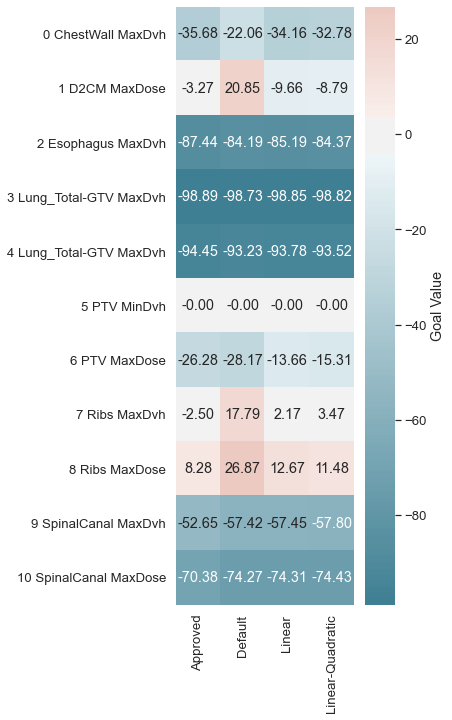

In [22]:
# Linear-Quadratic with Linear Rib had same solution as Linear
# Linear-Quadratic with Lower-Weighted Rib had same solution as Linear-Quadratic
idx_sol = [19, 20]
val_list = []
roi_dict = {}
for index, row in result.goal_df.iterrows():
    goal_vals = []
    level = row['AcceptanceLevel']
    roi_dict[f"{index} {row['Roi']} {row['Type']}"] = index
    goal_vals.append(100*(approved.goal_dict[index][0] - level)/level)
    goal_vals.append(100*(default.goal_dict[index][0] - level)/level)
    for idx in idx_sol:
        val = result.goal_dict[index][idx]
        goal_vals.append(100*(val - level)/level)
    val_list.append(goal_vals)
columns = ['Approved', 'Default', 'Linear', 'Linear-Quadratic']
val_df = pd.DataFrame(columns=columns, data=val_list, index=roi_dict)
ncols = len(columns)
fig, ax = plt.subplots(1, figsize=(ncols, len(result.goal_df)))
sns.heatmap(val_df, cmap=sns.diverging_palette(220, 20, n=256), center=0,
            annot=True, fmt=".2f", cbar_kws={'label': 'Goal Value'}, ax=ax)

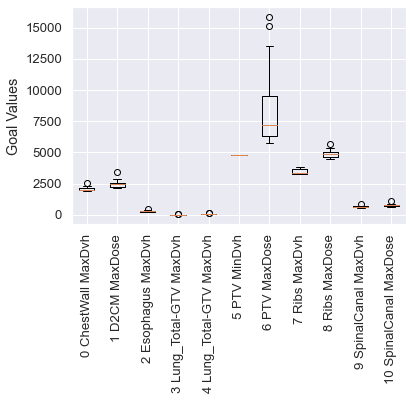

In [3]:
result.boxplot('goals')

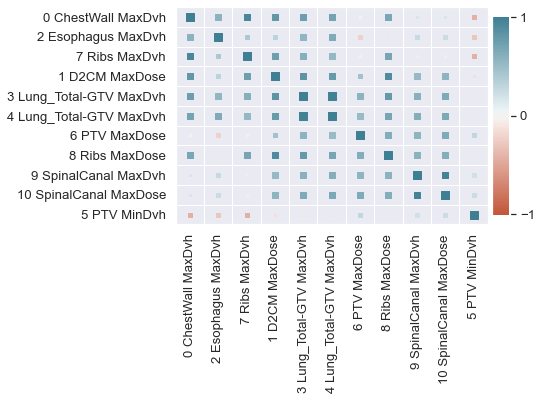

In [4]:
result.corrplot('goals')

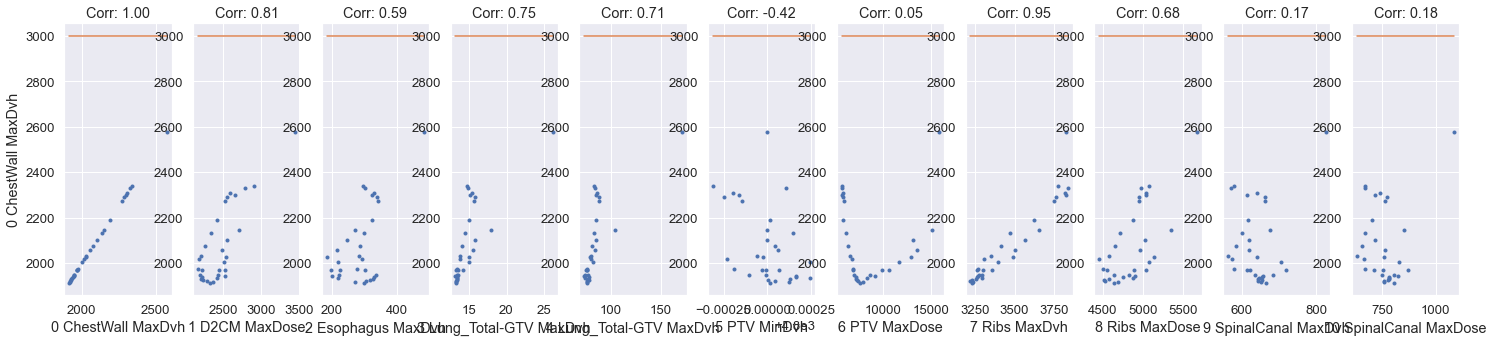

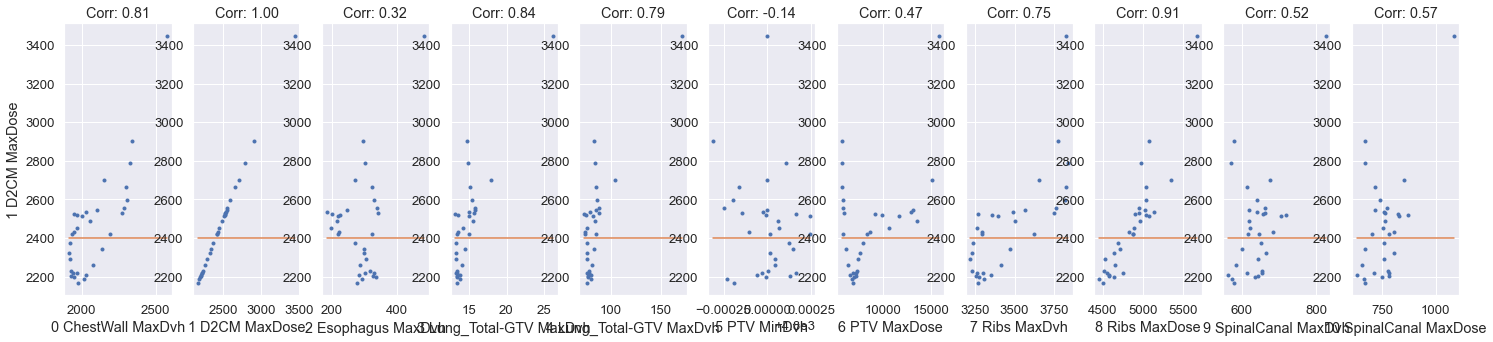

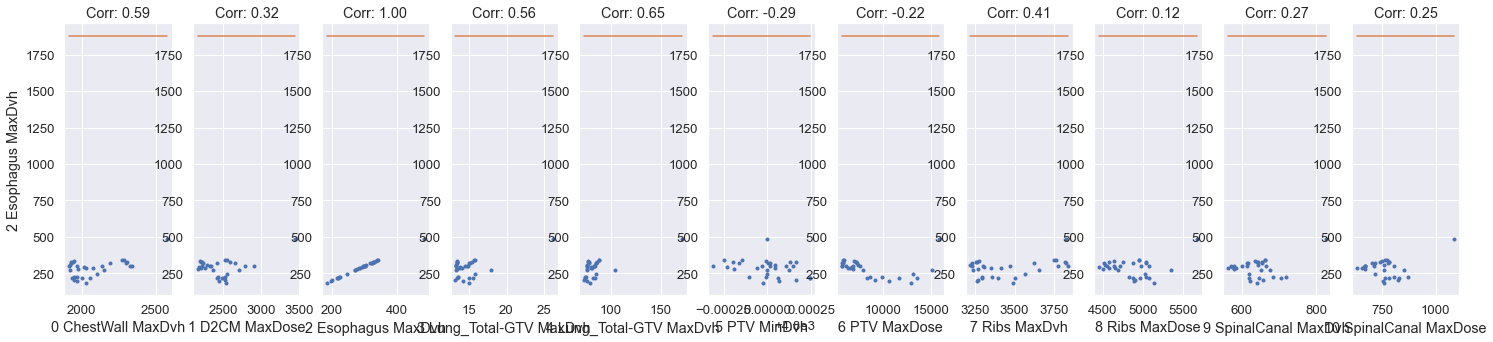

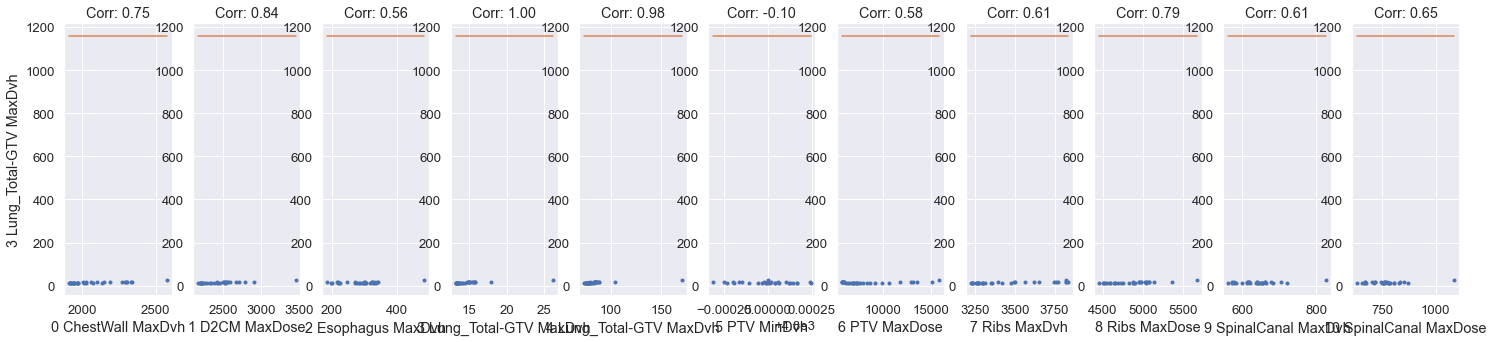

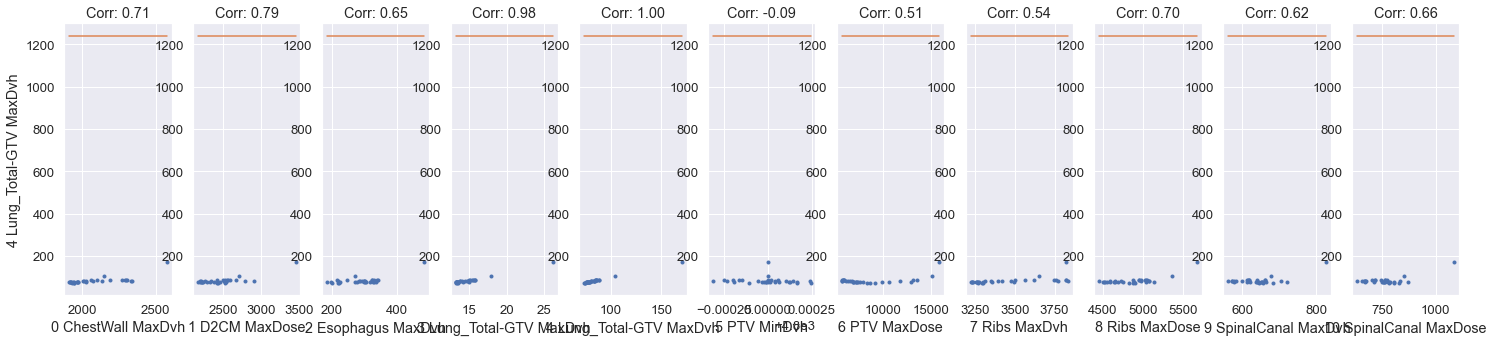

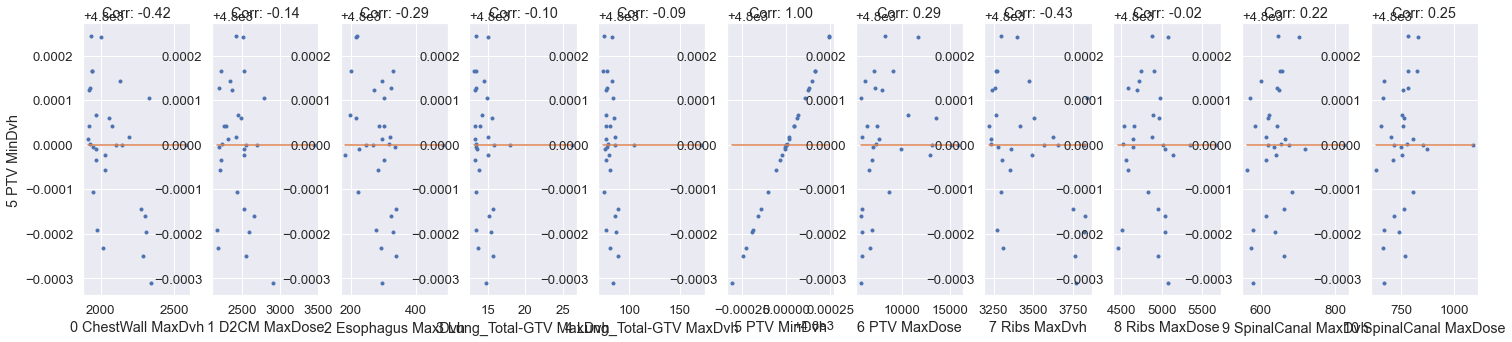

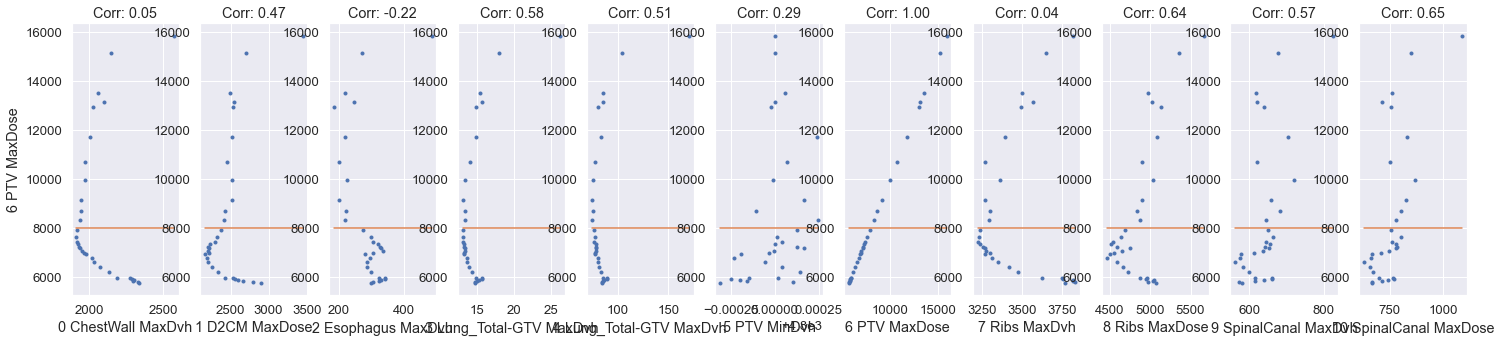

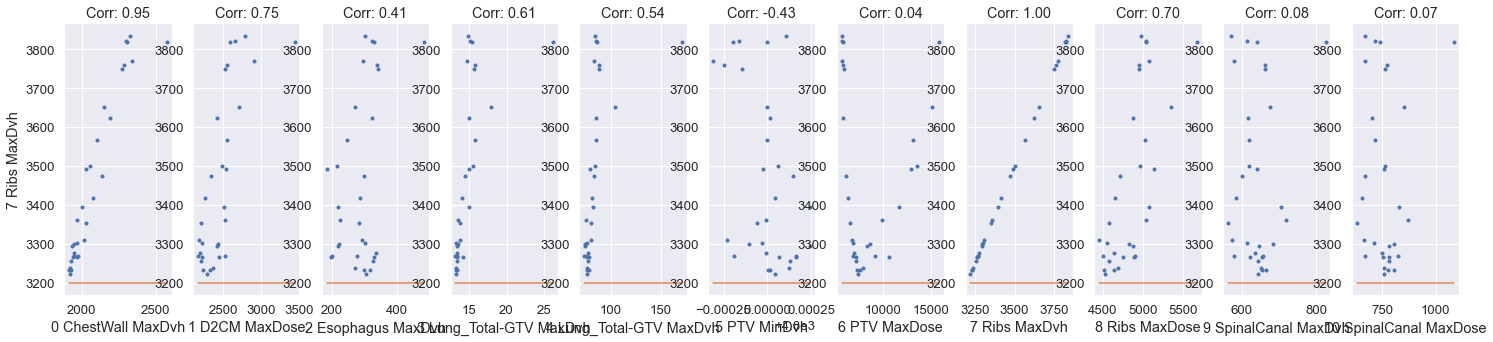

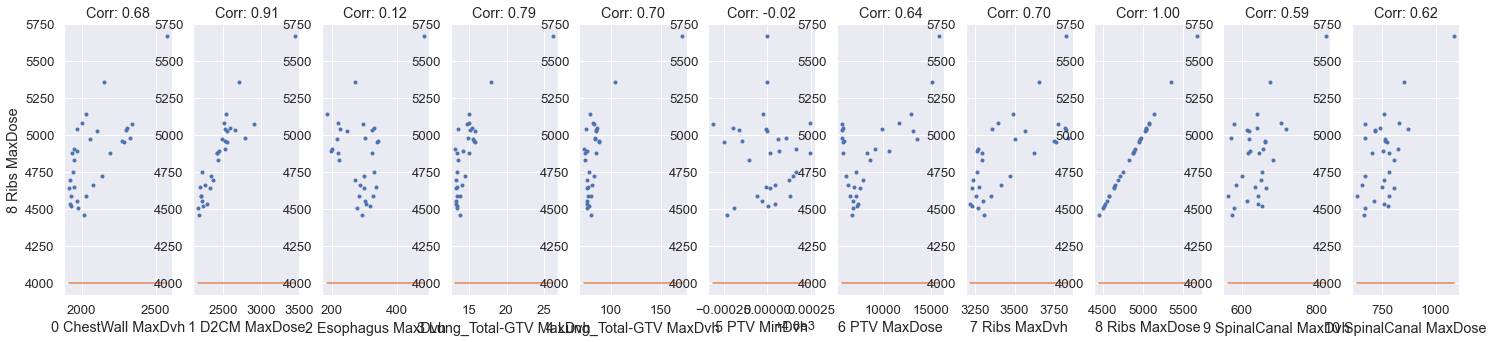

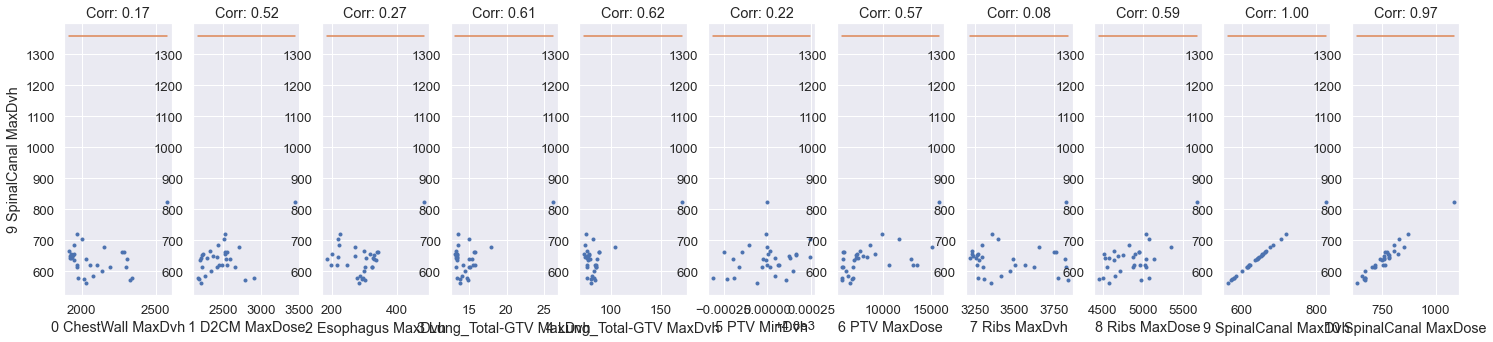

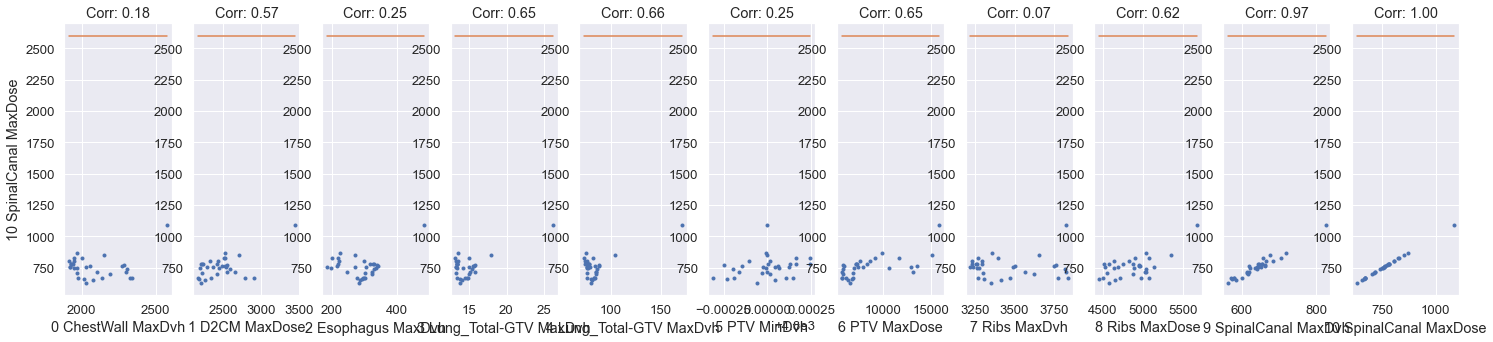

In [5]:
result.scatterplot('goals')

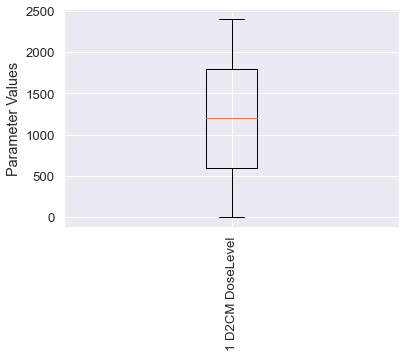

In [6]:
result.opt_result.x_iters = [[ii] for ii in result.opt_result.x_iters]
result.boxplot('pars')

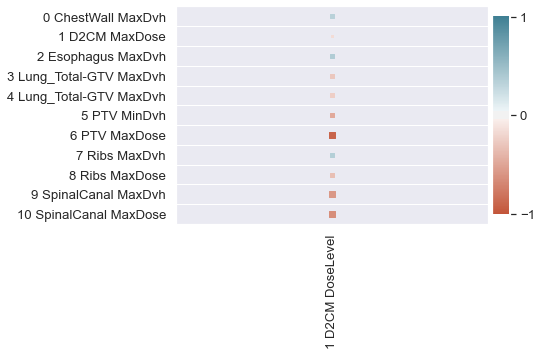

In [7]:
result.corrplot('pars')

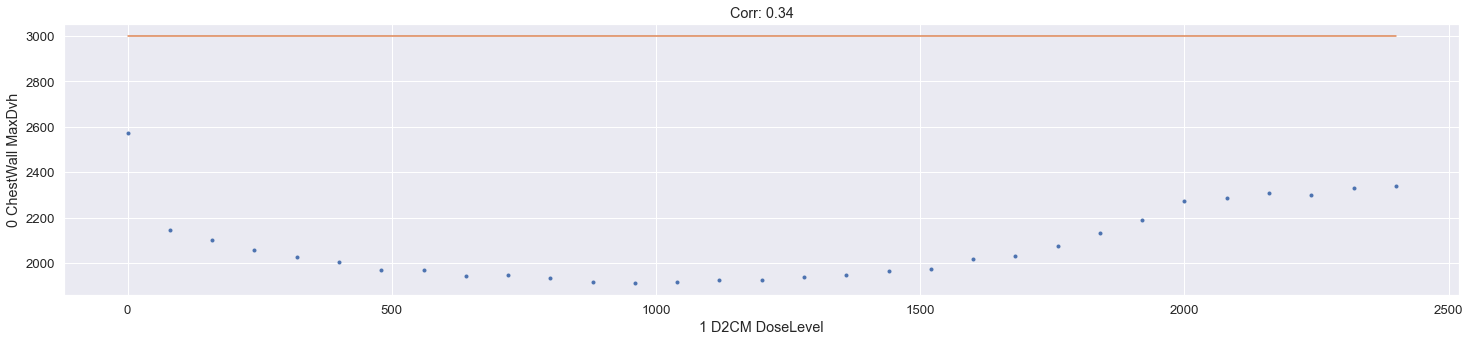

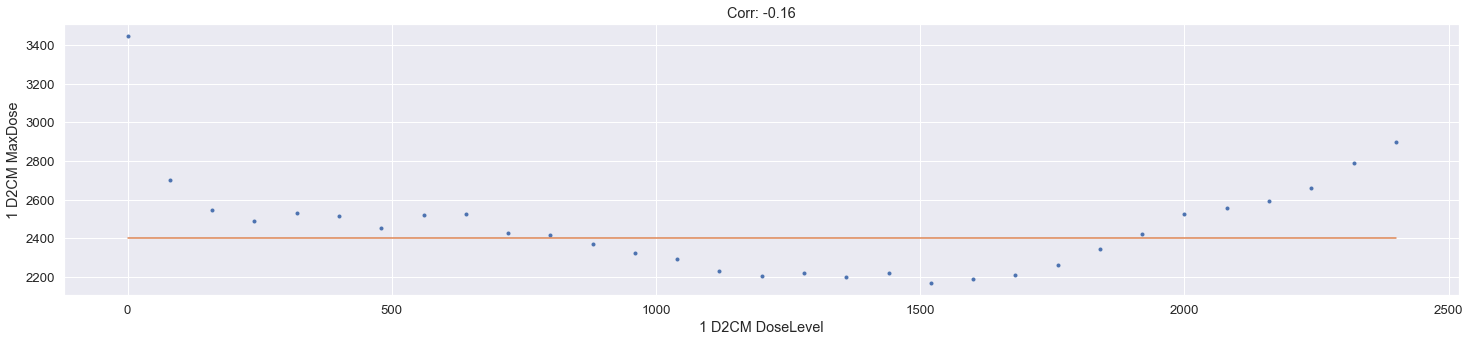

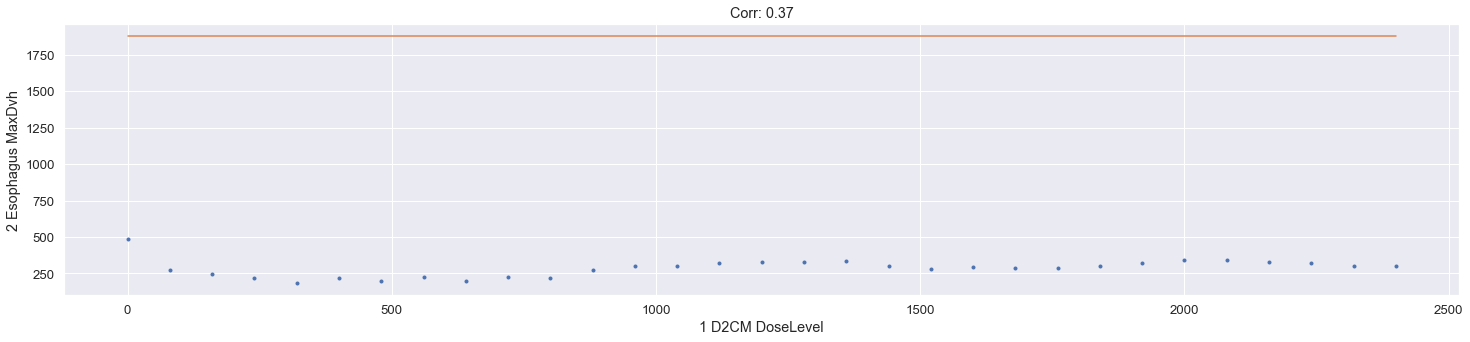

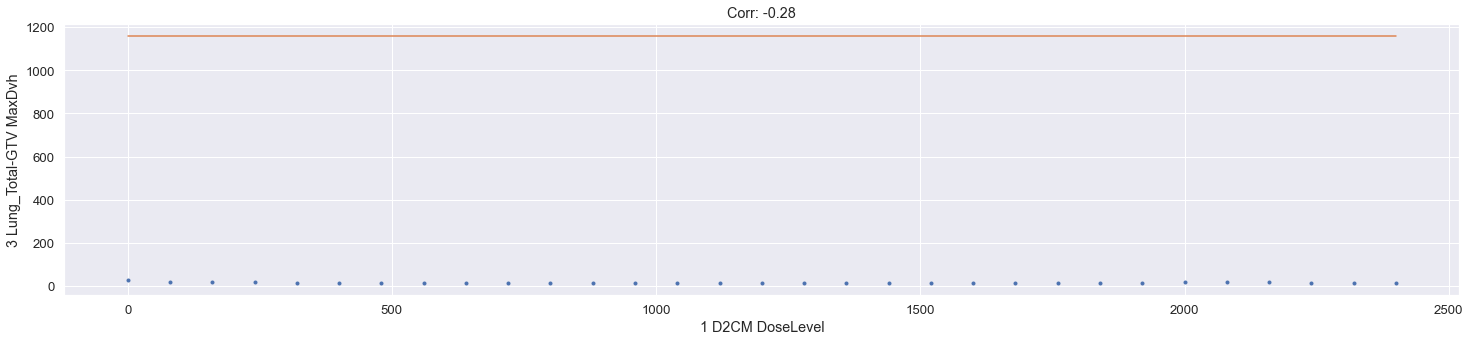

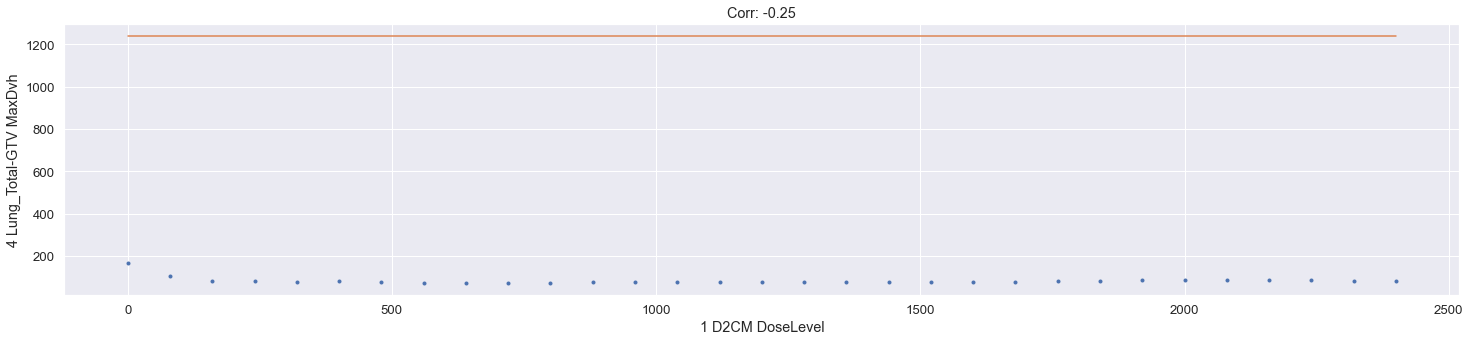

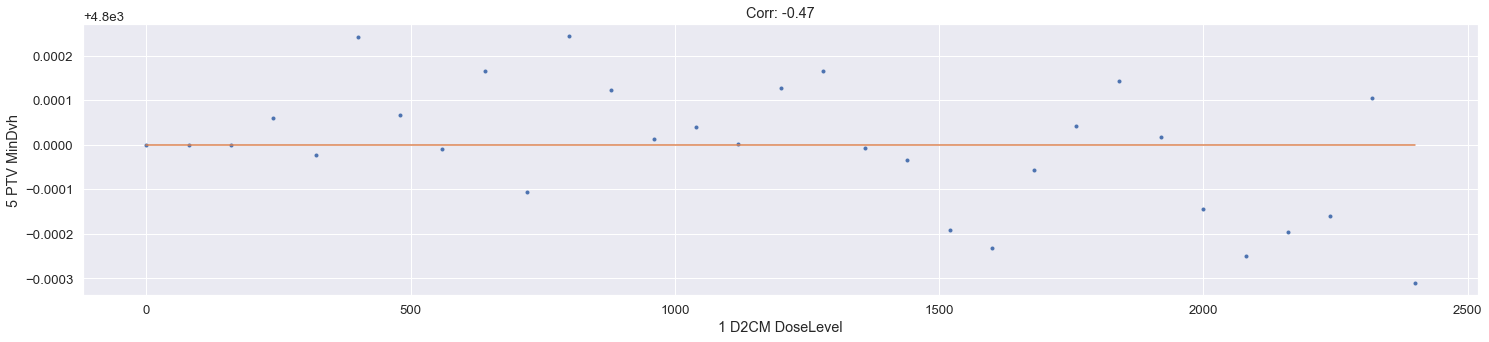

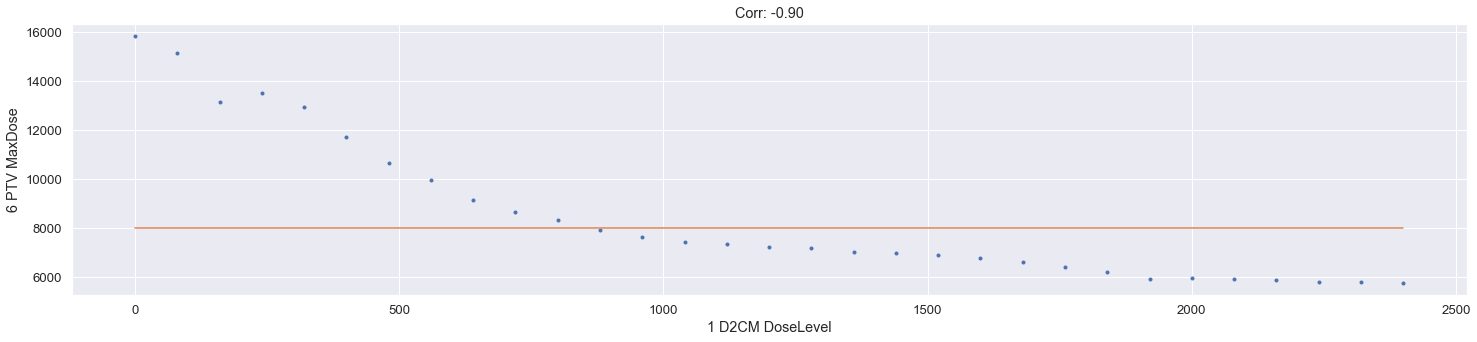

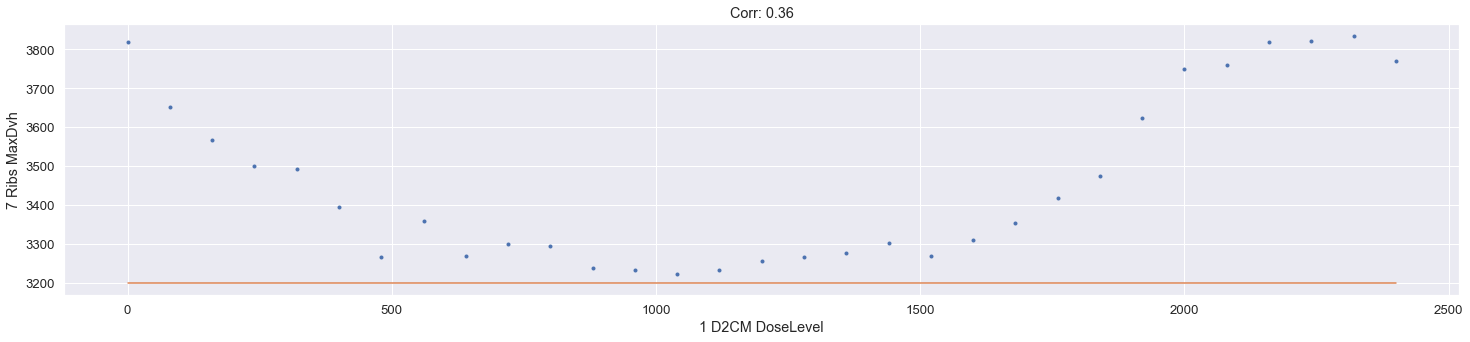

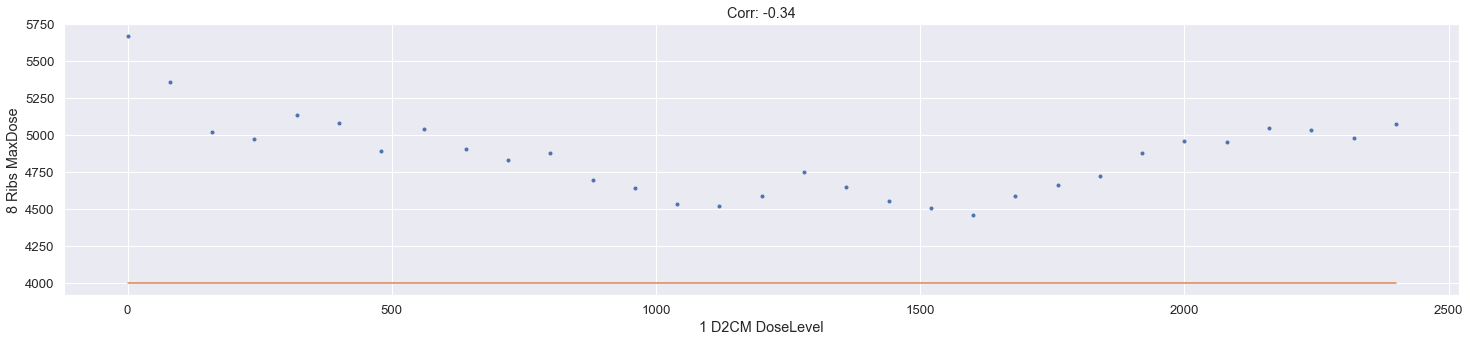

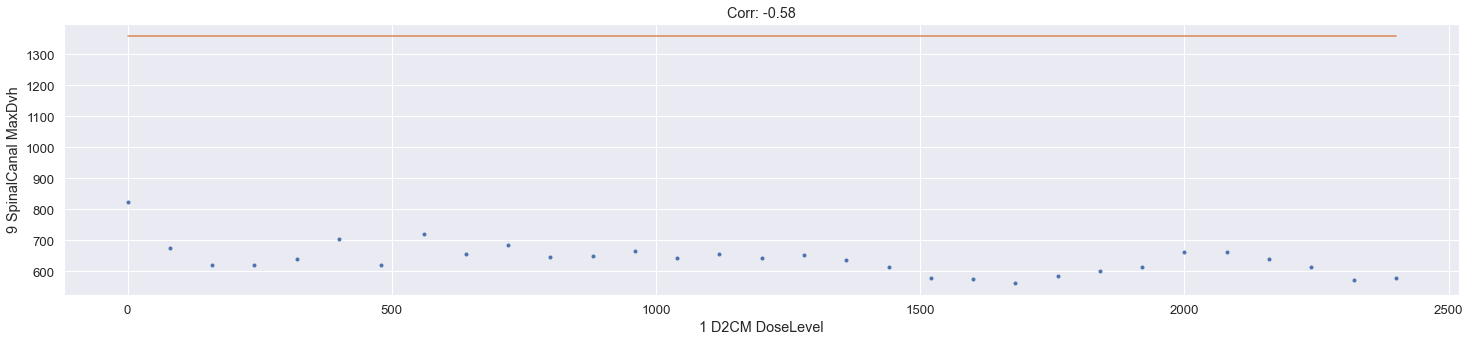

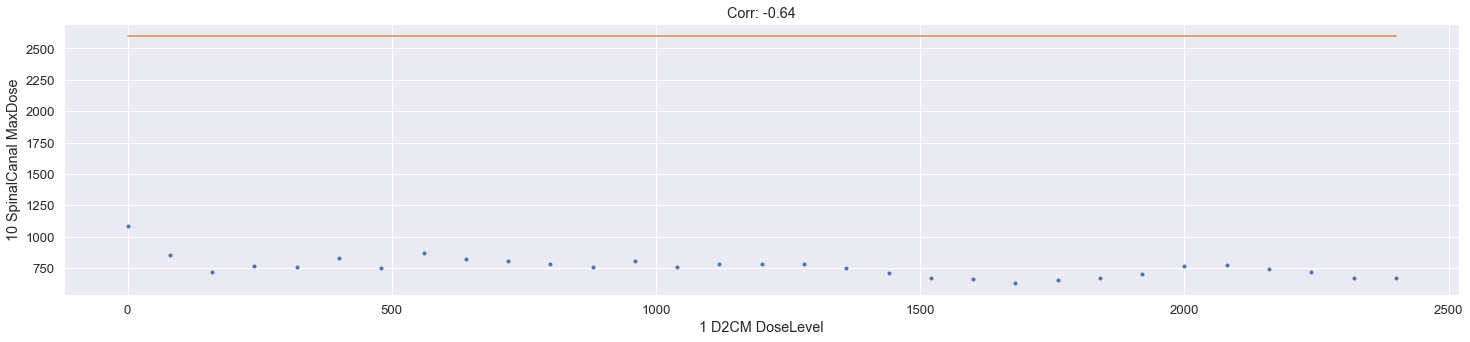

In [8]:
result.scatterplot('pars')

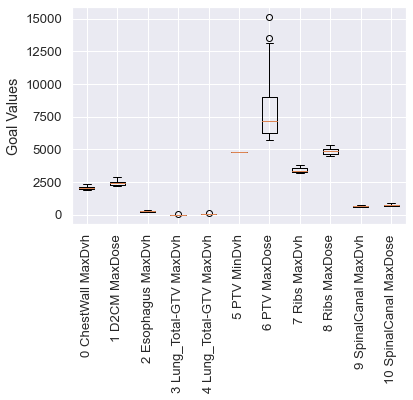

In [9]:
# Remove first iteration (outlier, flag=1)
goal_dict = {ii: result.goal_dict[ii][1:] for ii in result.goal_dict}
analyze.boxplot(result.goal_df, goal_dict, 'goals')

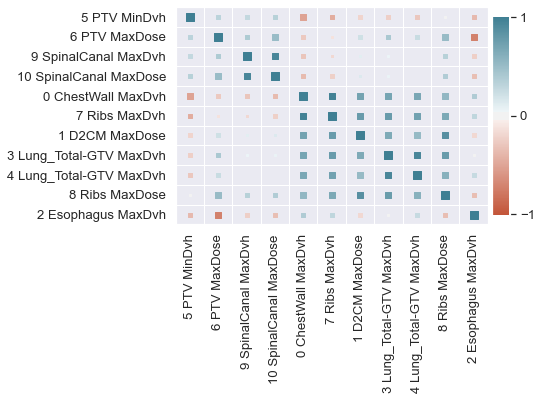

In [10]:
analyze.corrplot(result.goal_df, goal_dict)

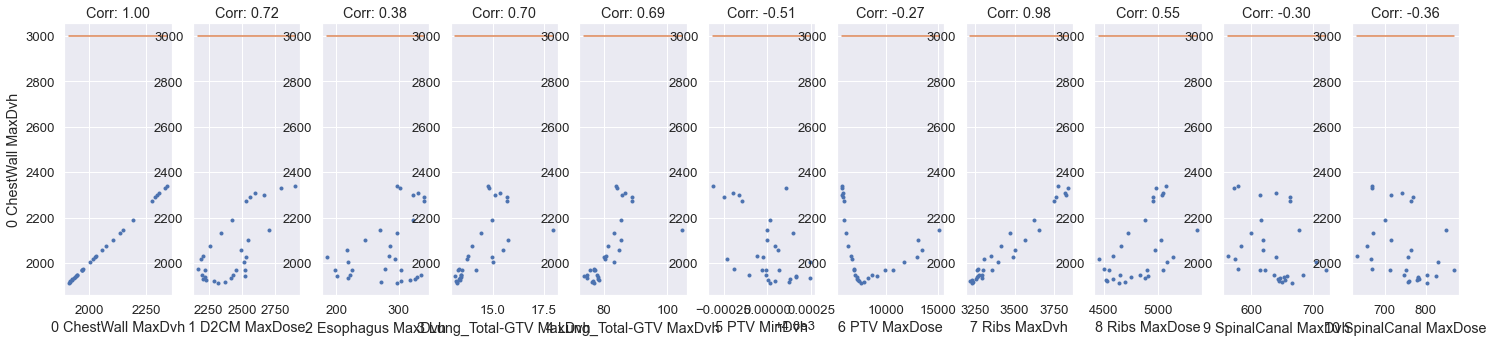

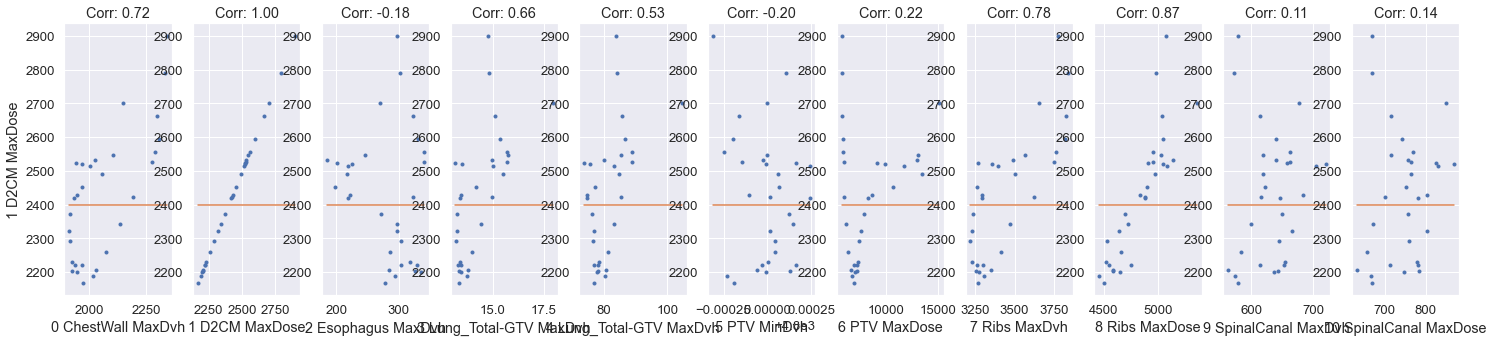

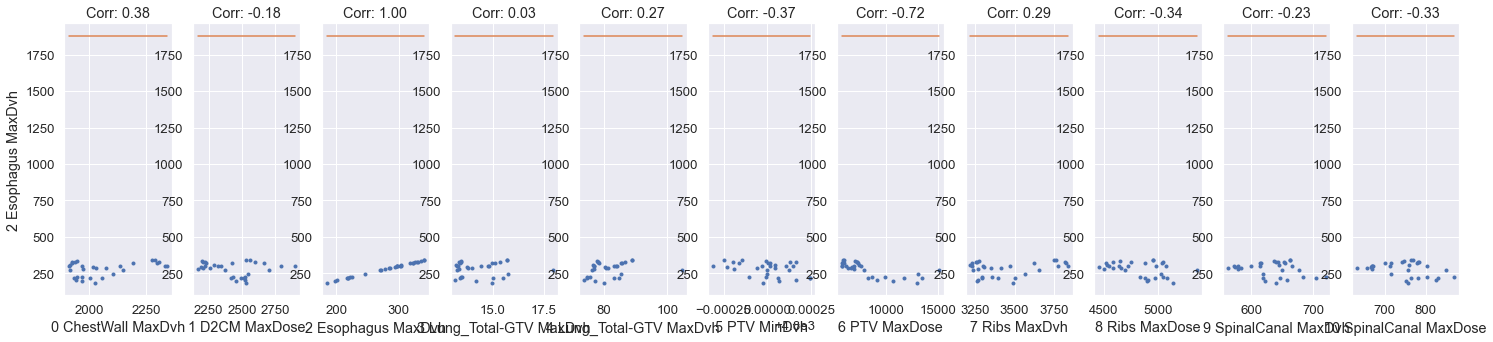

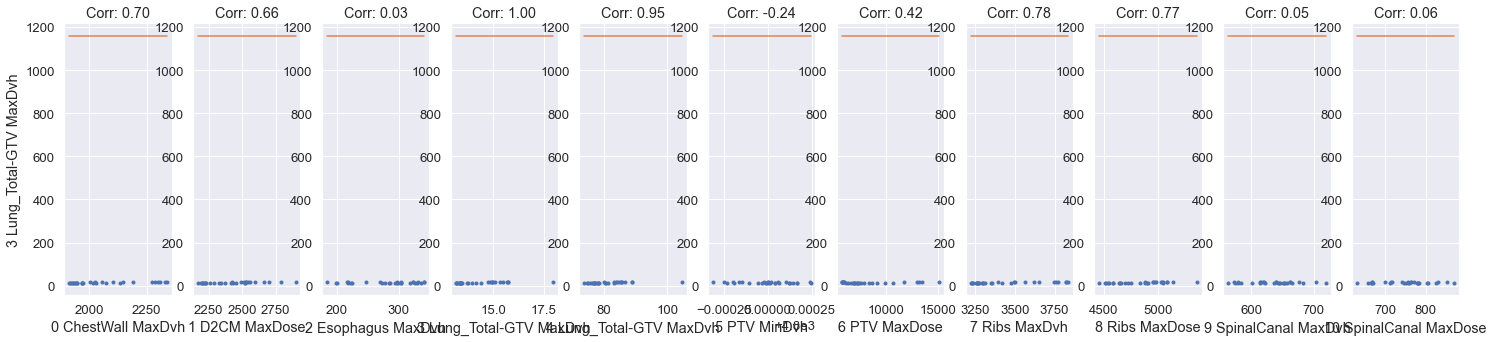

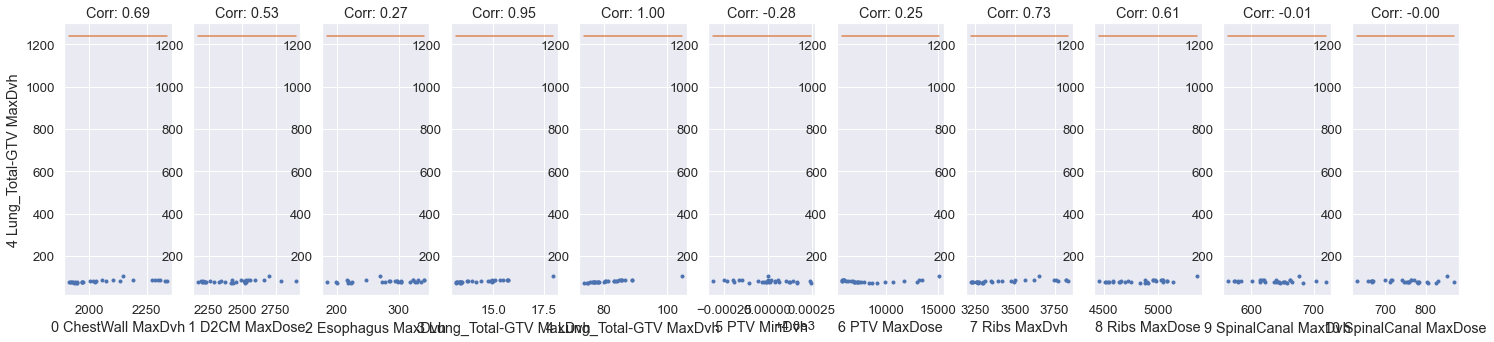

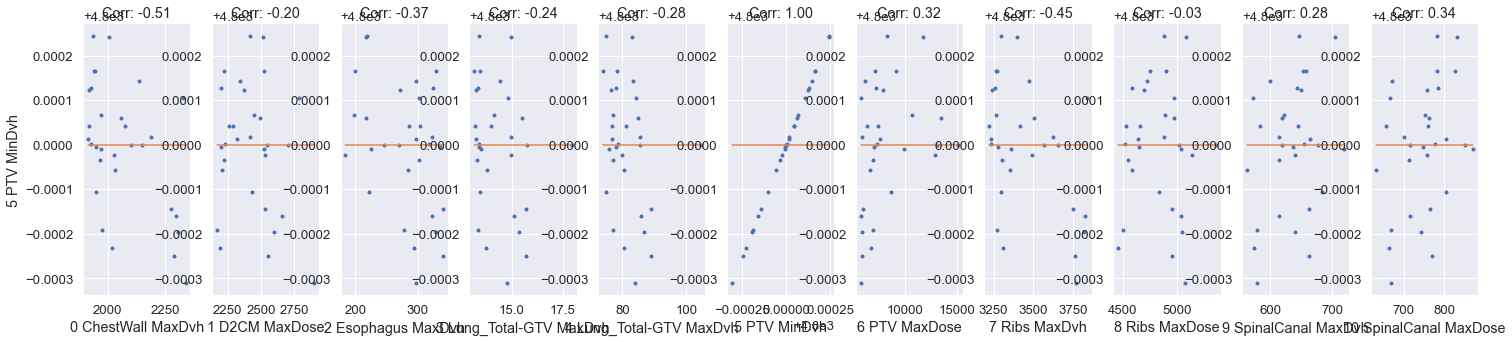

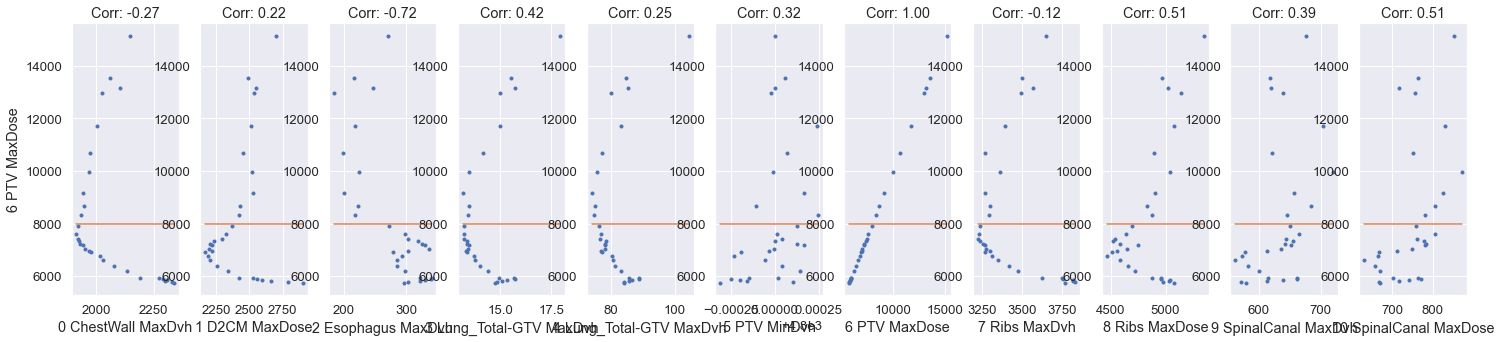

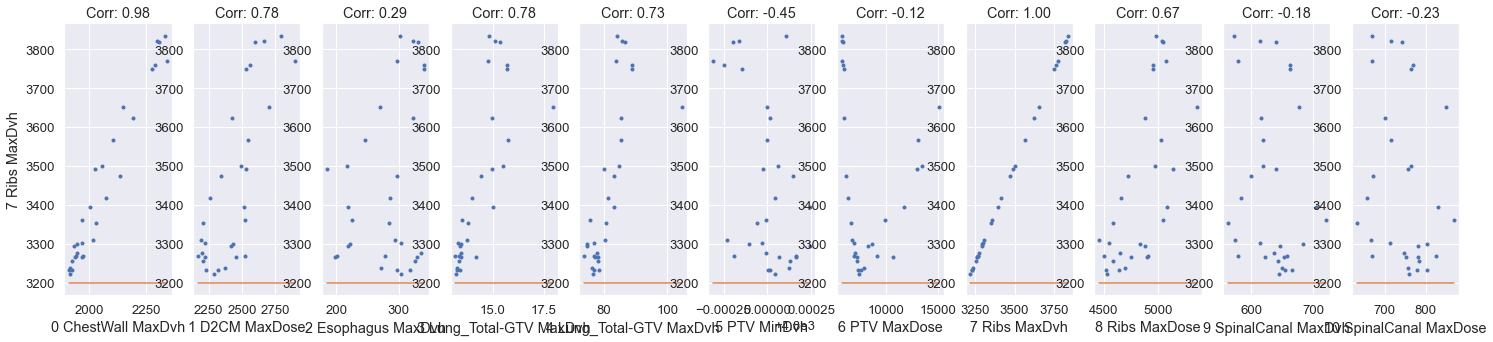

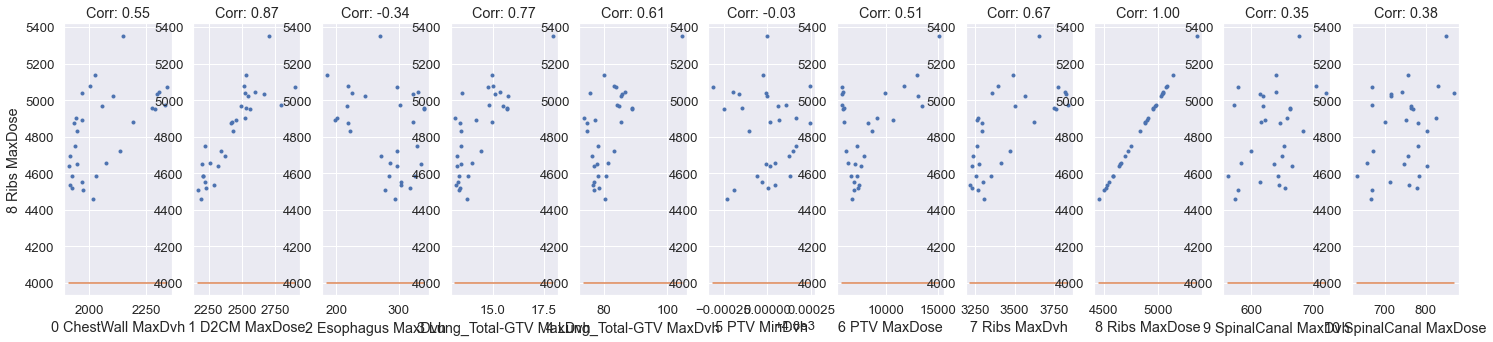

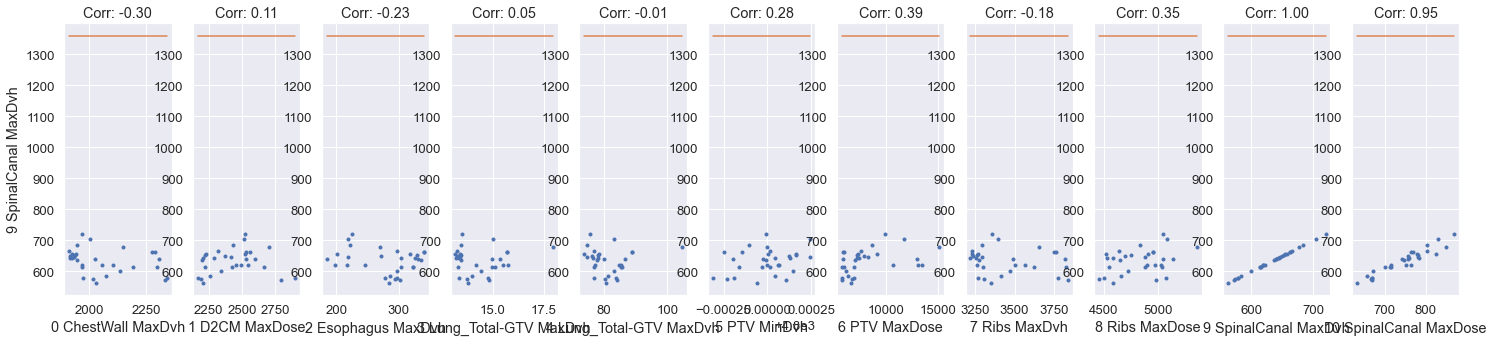

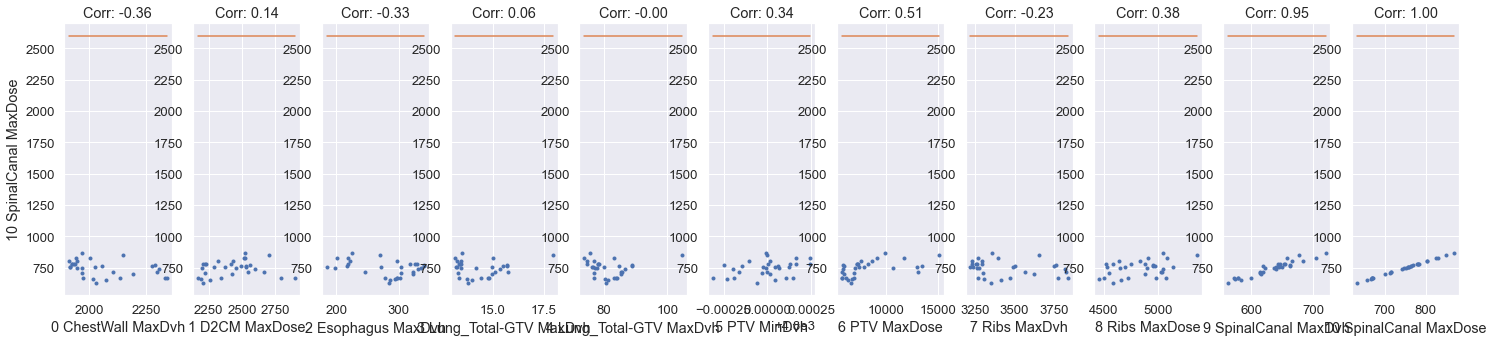

In [11]:
analyze.scatterplot(result.goal_df, goal_dict)

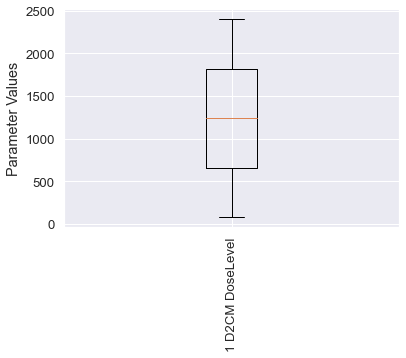

In [12]:
analyze.boxplot(result.func_df, result.opt_result.x_iters[1:], 'pars')

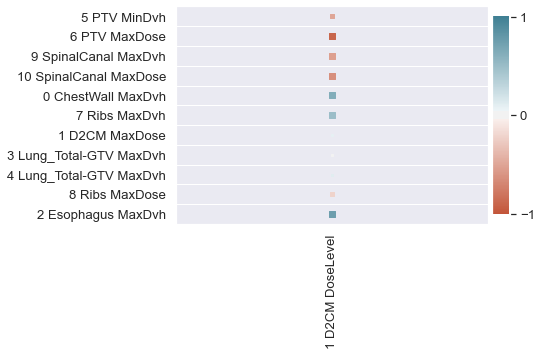

In [13]:
analyze.corrplot(result.goal_df, goal_dict, result.func_df, result.opt_result.x_iters[1:])

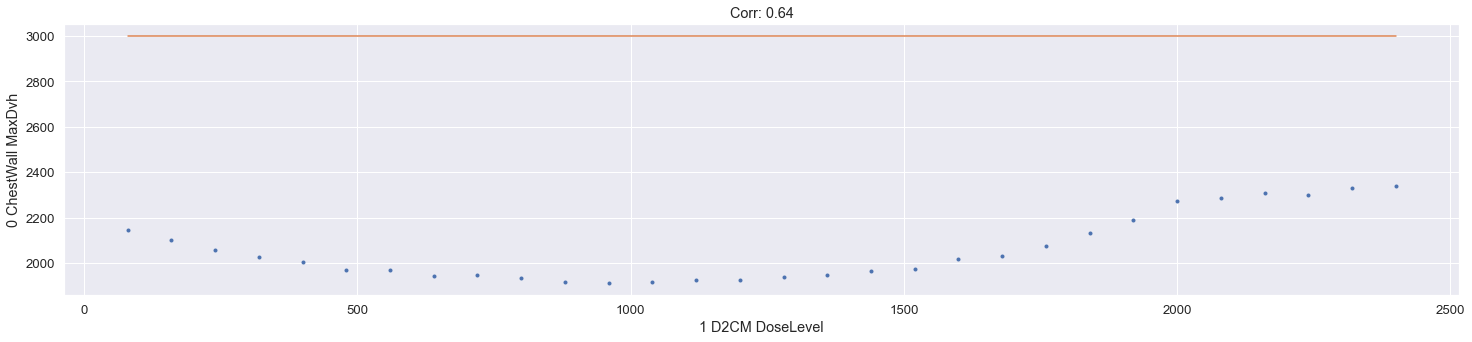

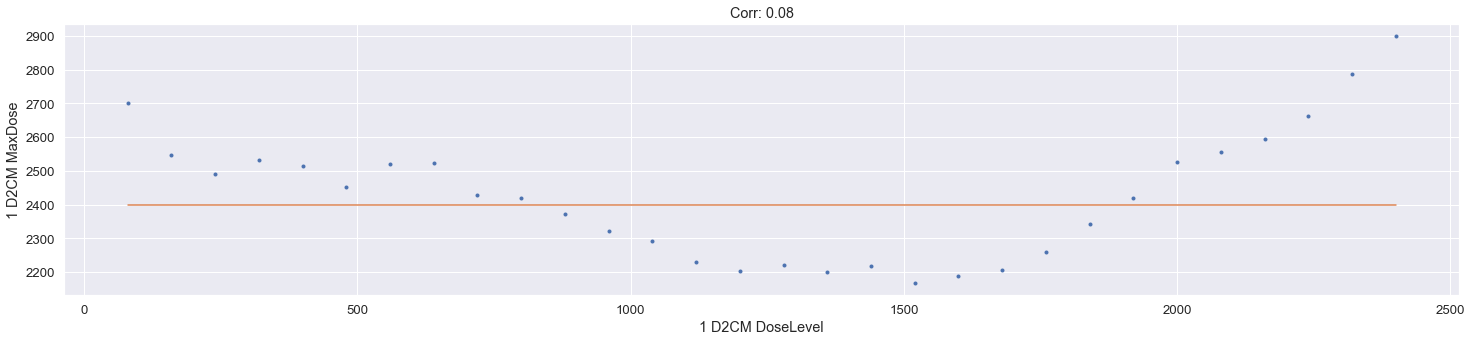

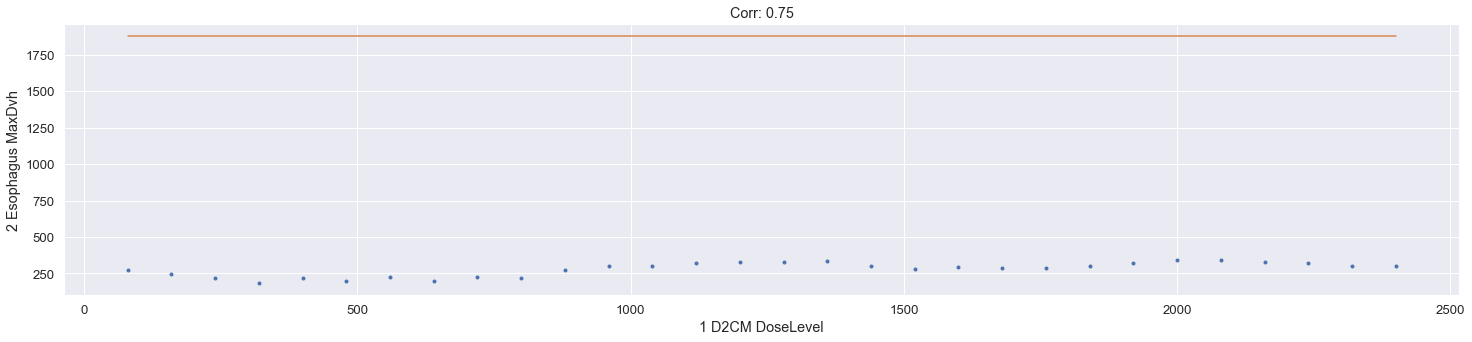

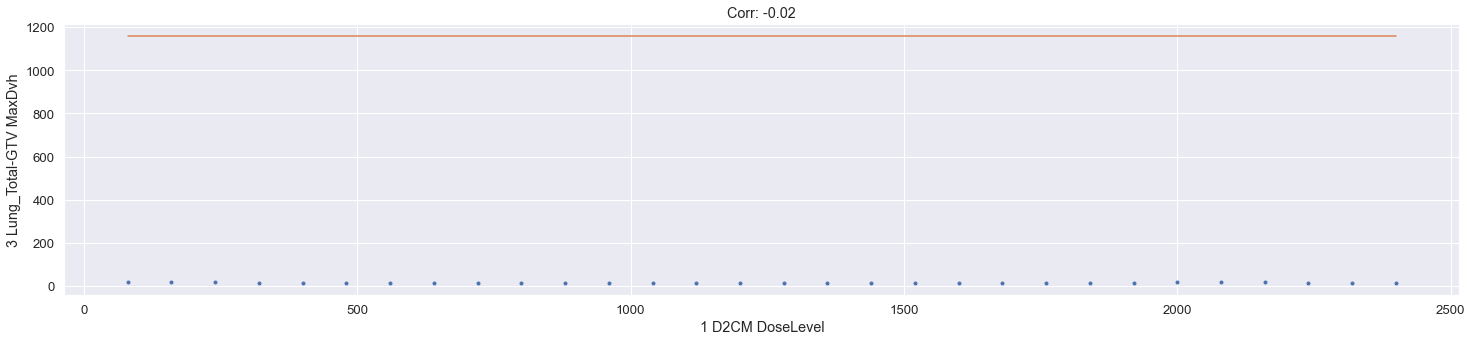

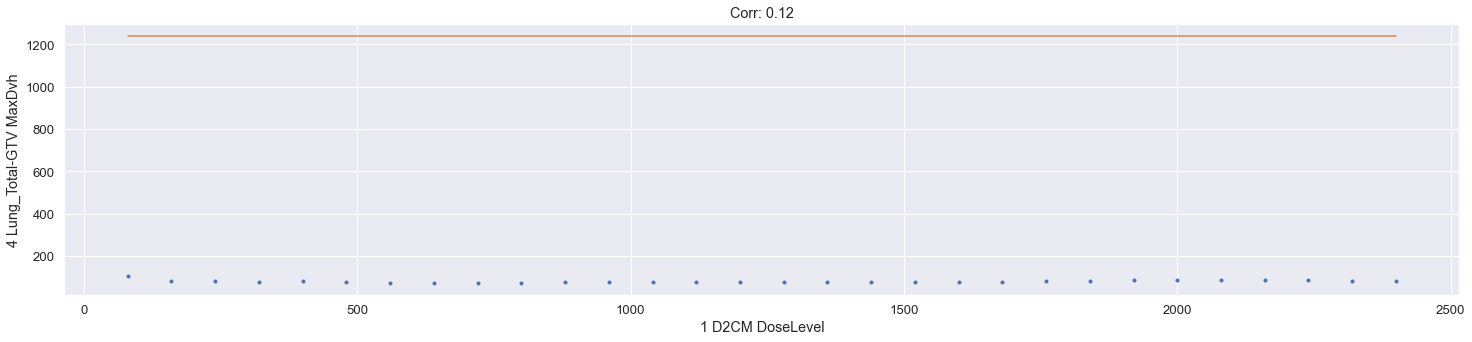

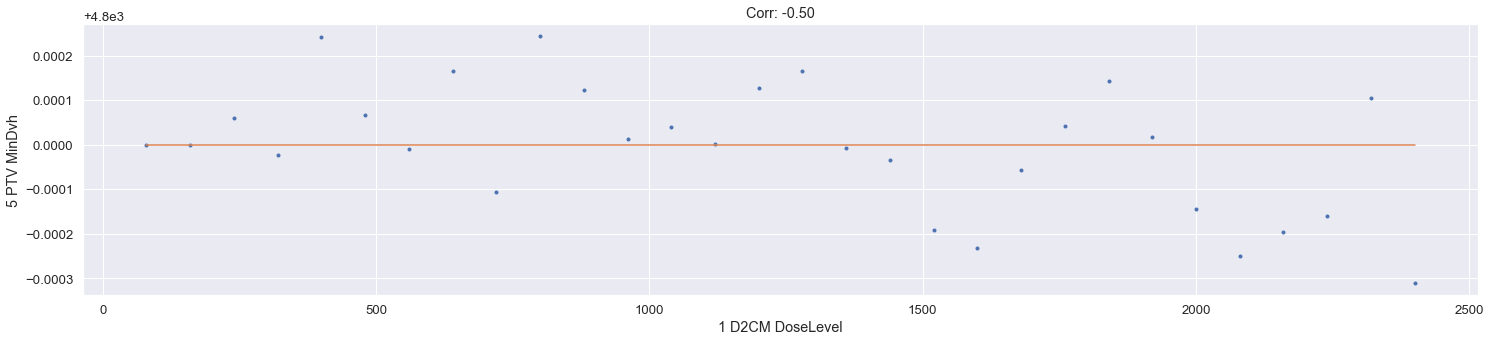

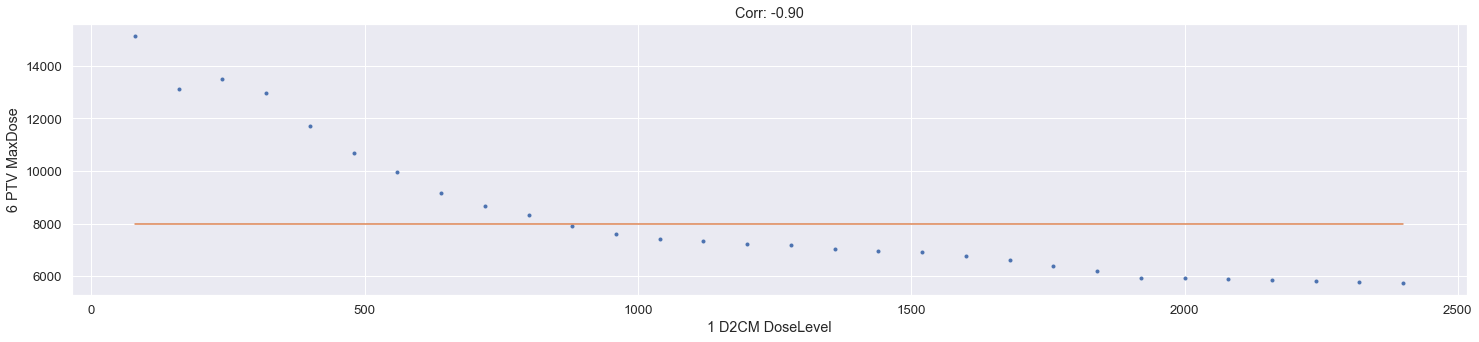

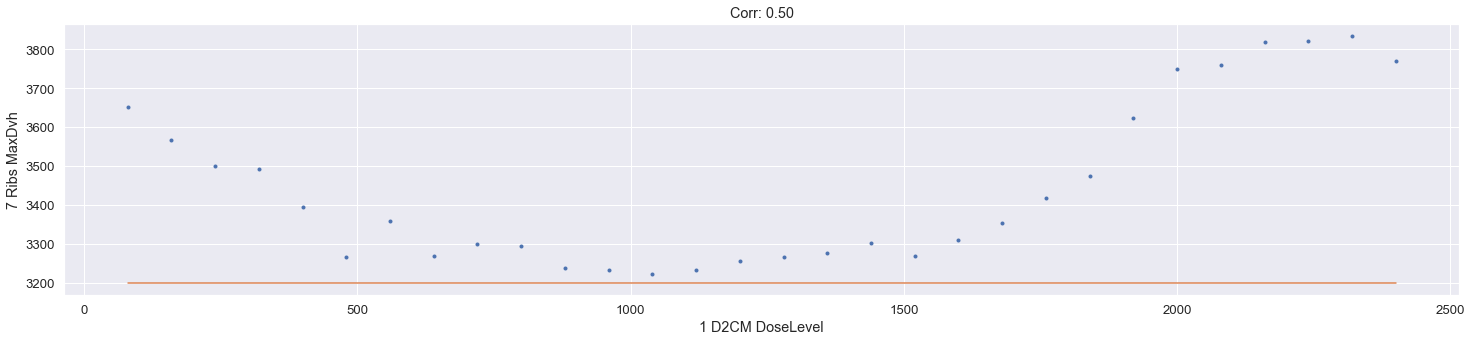

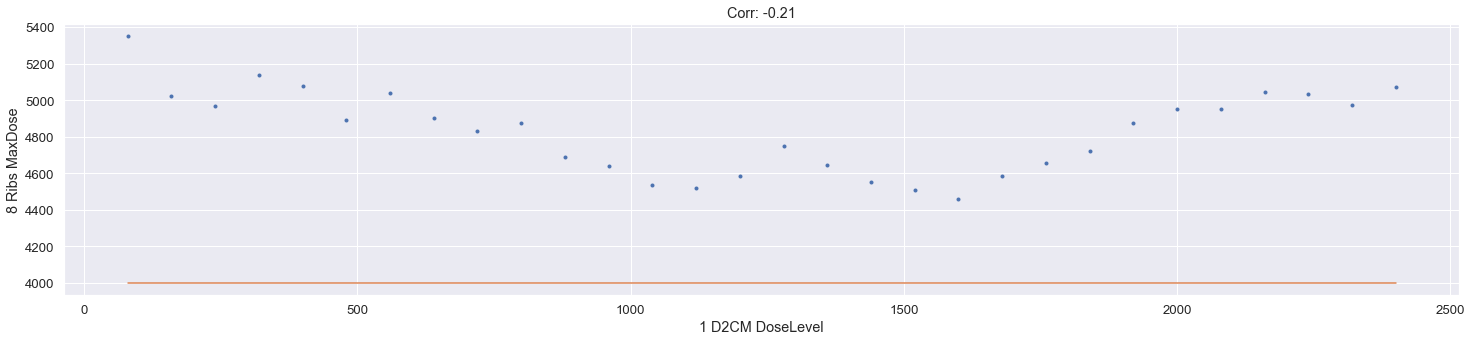

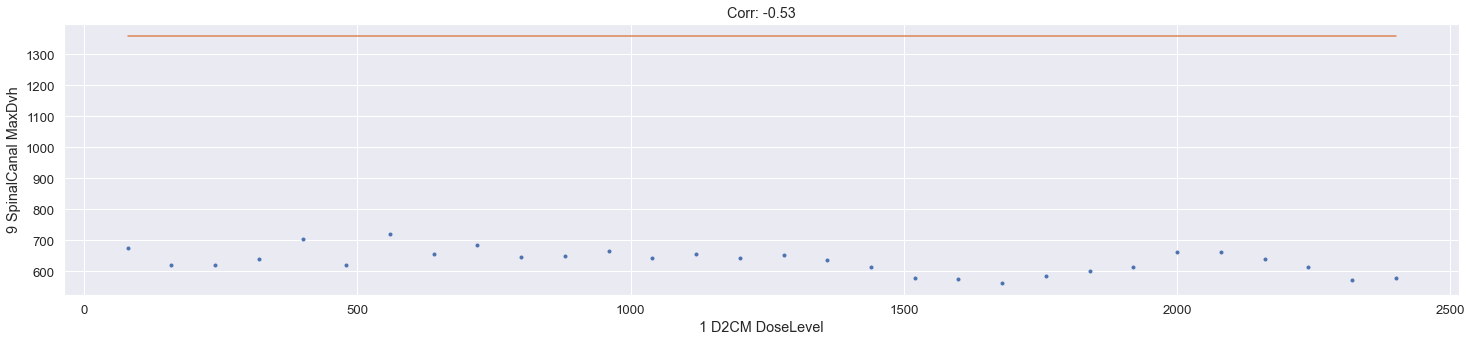

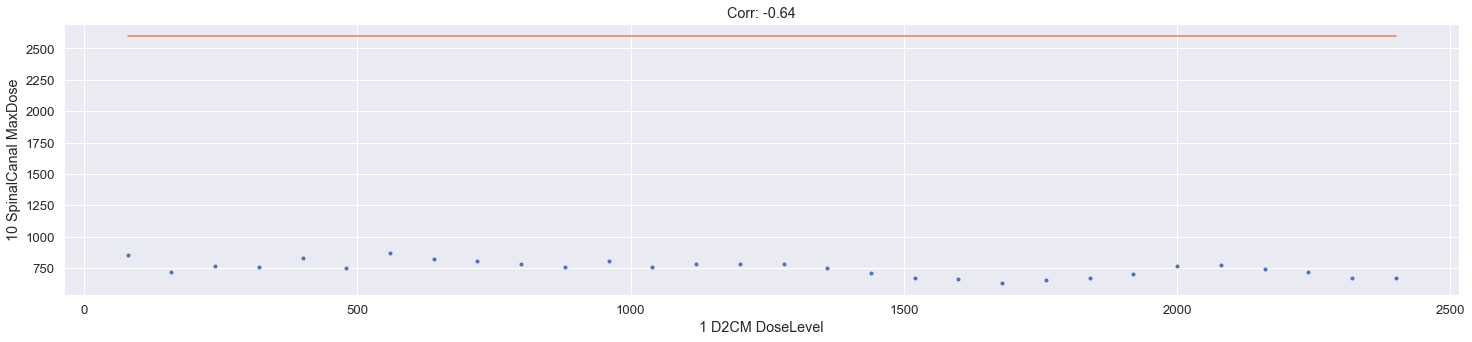

In [14]:
analyze.scatterplot(result.goal_df, goal_dict, result.func_df, result.opt_result.x_iters[1:])